# The Kuzmin-Toomre Disk

This model represents a **thin disk** with a **central bulge-like concentration** of mass.  it is useful for studying **stellar orbits**, **disk stability**, and **dynamical modeling** of galaxies. The **vertical mass distribution** is represented by the parameter $a$, controlling how **"thick"** the disk is.  

The surface mass density $\Sigma(r)$ is:

$$
\Sigma(r) = \frac{Ma}{2\pi(r^2 + a^2)^{3/2}}
$$


The gravitational potential $\Phi(r, z)$ is:

$$
\Phi(r, z) = -\frac{GM}{\sqrt{r^2 + (a + |z|)^2}}
$$

where $M$ is the **total mass** of the disk and $a$ is the **scale length** of the disk.  

The circular velocity at the disk plane ($z = 0$) is:

$$
v_c(r) = \sqrt{\frac{GM r^2}{(r^2 + a^2)^{3/2}}}
$$

- At **small radii** ($r \ll a$), $v_c \propto r$ (solid-body rotation).  
- At **large radii** ($r \gg a$), $v_c \propto \frac{1}{\sqrt{r}}$ (Keplerian decline).  


**Stability**

The **axisymmetric stability** of a stellar disk can be evaluated using the **Toomre's Q parameter** for stars:

$$
Q = \frac{\sigma_r \kappa}{3.36 G \Sigma}
$$

Where $\sigma_r$ is the **radial velocity dispersion** of stars, $\Sigma$ is the **surface mass density** of the disk and $\kappa$ is the **epicyclic frequency** (the frequency of small radial oscillations of an object in a nearly circular orbit around a central mass), which for a **Kuzmin-Toomre disk** is related to the **rotation curve** $v_c(r)$ by:

$$
\kappa = \sqrt{2} \frac{v_c}{r} \sqrt{1 + \frac{r}{v_c} \frac{dv_c}{dr}} = 2 \Omega \sqrt{1-\frac{3}{4(1+a^2/r^2)}}
$$
  
Since surface density $\Sigma(r)$ and epicyclic frequency $\kappa(r)$ are functions of radius, $\sigma_r$ must also vary with radius to maintain a stable disk. In the outer regions of the disk, where the surface density $\Sigma(r)$ decreases, the velocity dispersion must increase to provide support against gravitational collapse.

- The disk is **axisymmetrically stable** if $Q > 1$.  
- If $Q < 1$, the disk is prone to **local axisymmetric instabilities**, leading to **ring-like structures**.  

For the **Kuzmin-Toomre disk**, maintaining a **high enough velocity dispersion** $\sigma_r$ is crucial for **stability**.

The Toomre Q parameter is a good measure of radial stability, but a real stellar disk is not purely 2D. It has motions in all three dimensions, and the stability of the disk depends on how well-supported it is against perturbations in each direction:

Radial stability: Governed by $Q$ with $\sigma_r$​.

Azimuthal stability: Related to the support against non-axisymmetric perturbations, like spiral arm formation. The epicyclic approximation links $\sigma_\phi$ to $\sigma_r$​ through:

$$\sigma_\phi = \sigma_r \frac{k}{2\Omega}$$

Vertical stability: Described by $\sigma_{z}$​, which provides support against vertical collapse of the disk. It is particularly important if the disk has a finite thickness, where the vertical Jeans criterion may apply:

$$\sigma_z \gtrsim \sqrt{2\pi G\Sigma h}$$

where $h$ is the scale height of the disk.


**GENERATING KUZMIN-TOOMRE DISK**

Cylindrical symmetry:
$$dV = (R dR)(d\phi)(dz)$$

$$p(R,z) = \frac{1}{M} 2 \pi R \rho(R,z) = \frac{1}{M} 2 \pi R\frac{aM}{2\pi (R^2+a^2)^{3/2}}\delta(z)$$

$$P(R,z)=\int_0^R \int_0^z p(R,z)dRdz = \int_0^R  \frac{aR}{(R^2+a^2)^{3/2}}dR = 1-\frac{a}{\sqrt{R^2+a^2}} \text{ for }z=0$$

$$R(P)=\sqrt{\left (\frac{a}{1-P}\right)^2-a^2}$$

In [1]:
from myTreecode import Star
from myTreecode import Tree
from myTreecode import grav_force_star_node
from myTreecode import evolve
from view import view

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [3]:
time_conversion_factor = 14.910128      # 1 IU in Myrs
velocity_conversion_factor = 0.06558093063931242  # 1 IU in Km/s 
time_conversion_factor_s = 470563626066861.375000 # 1 IU in s

In [88]:
class Kuzmin_Toomre:
    
    def __init__(self,N,a,Q,m=1):
        self.N = int(N) 
        self.a = a 
        self.m = m 
        self.M = self.N * self.m 
        
        self.Q = Q         # Toomre parameter
        
        print(f"Kuzmin-Toomre disk with {self.N} stars of mass {m:.2f} solar masses. Scale parameter a parameter is {self.a:.2f} parsecs. "
             f"Toomre parameter Q is {self.Q:.2f}")
        
        # initialize system
        
        self.t = [0]
        self.system = []

        initial_conditions = []
        
        for i in range(self.N):
            u = random.uniform(0,1)
            w = random.uniform(0,1)
            R = np.sqrt((self.a/(1-u))**2-self.a**2) 
            phi = 2*np.pi*w 

            x = np.array([R*np.cos(phi),R*np.sin(phi),0.0])
            
            v_circ = R * self.M**(1/2) * (R**2+self.a**2)**(-3/4)
            
            local_density = (self.M*self.a/(2*np.pi))/(R**2+self.a**2)**(3/2)
            
            k = 2 * v_circ / R * np.sqrt(1 -3/4 /(1+self.a**2/R**2))
            
            sigma_r = self.Q * 3.36 * local_density / k
            
            v_R = np.random.normal(loc=0, scale=sigma_r)

            sigma_phi = sigma_r * k / (2 * v_circ/R)

            v_phi = v_circ + np.random.normal(loc=0, scale=sigma_phi)

            sigma_z = sigma_r / 2

            v_z =  np.random.normal(loc=0, scale=sigma_z)
            
            v = np.array([-v_phi*np.sin(phi)-v_R*np.cos(phi),v_phi*np.cos(phi)-v_R*np.sin(phi),v_z])
            
            initial_conditions.append(Star(self.m, x, v))
        self.system.append(np.array(initial_conditions))


        R_typical = np.quantile([star.r for star in initial_conditions],0.5)
        self.v_typical = R_typical * self.M**(1/2) * (R_typical**2+self.a**2)**(-3/4)
        self.t_orbit = 2*np.pi*R_typical / self.v_typical

        print(f"Characteristic velocity is {self.v_typical:.2e} in internal units, "
              f"{self.v_typical * velocity_conversion_factor:.2e} km/s. ")
        print(f"Characteristic orbital period is {self.t_orbit:.2e} in internal units, "
              f"{self.t_orbit * time_conversion_factor:.2e} Myr. ")
              #f"Relaxation time is {self.t_relax:.2e} in internal units, "
              #f"{self.t_relax * time_conversion_factor:.2e} Myr.")


In [143]:
kuz_0 = Kuzmin_Toomre(N = 5000,a = 10, m = 1, Q = 2)
indexes = []
for i in range(15):
    r_min = i * 10
    r_max = (i + 1) * 10
    stars_in_bin = [star for star in kuz_0.system[0] if r_min < star.r < r_max]
    if stars_in_bin:
        lucky_star = random.choice(stars_in_bin)  # Randomly select the lucky star
        lucky_index = np.where(kuz_0.system[0] == lucky_star)[0][0]  # Find the index of the lucky star
        indexes.append(lucky_index)


Kuzmin-Toomre disk with 5000 stars of mass 1.00 solar masses. Scale parameter a parameter is 10.00 parsecs. Toomre parameter Q is 2.00
Characteristic velocity is 1.38e+01 in internal units, 9.02e-01 km/s. 
Characteristic orbital period is 7.63e+00 in internal units, 1.14e+02 Myr. 


In [145]:
evolve(kuz_0,tstop = 2,dt = 0.1,dtout=0.2,eps=0.01,theta = 2,orbit_indexes=indexes)

Evolving system:   0%|          | 0/2 [00:00<?, ?it/s]

In [153]:
view(kuz_0,r_max=40,t=np.linspace(kuz_0.t[0],kuz_0.t[-1],6))

In [149]:
kuz_1 = Kuzmin_Toomre(N = 5000,a = 10, m = 1, Q = 0)
indexes = []
for i in range(15):
    r_min = i * 10
    r_max = (i + 1) * 10
    stars_in_bin = [star for star in kuz_1.system[0] if r_min < star.r < r_max]
    if stars_in_bin:
        lucky_star = random.choice(stars_in_bin)  # Randomly select the lucky star
        lucky_index = np.where(kuz_1.system[0] == lucky_star)[0][0]  # Find the index of the lucky star
        indexes.append(lucky_index)


Kuzmin-Toomre disk with 5000 stars of mass 1.00 solar masses. Scale parameter a parameter is 10.00 parsecs. Toomre parameter Q is 0.00
Characteristic velocity is 1.37e+01 in internal units, 9.01e-01 km/s. 
Characteristic orbital period is 7.73e+00 in internal units, 1.15e+02 Myr. 


In [150]:
evolve(kuz_1,tstop = 2,dt = 0.1,dtout=0.2,eps=0.01,theta = 2,orbit_indexes=indexes)

Evolving system:   0%|          | 0/2 [00:00<?, ?it/s]

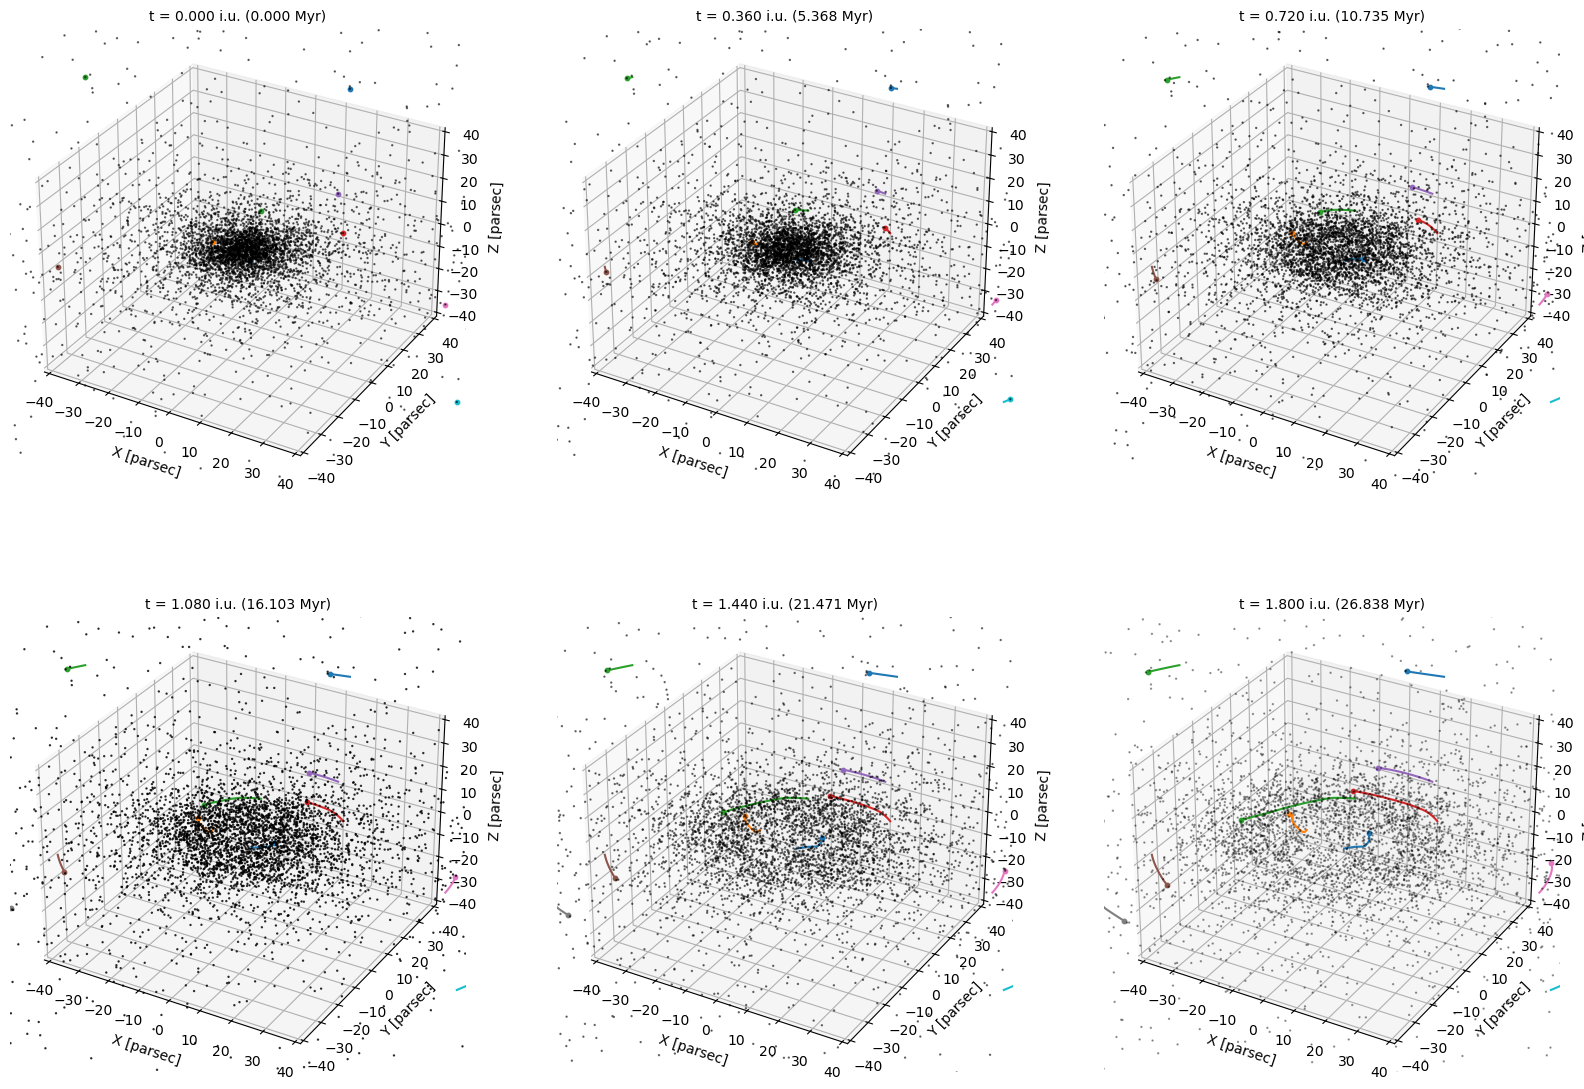

In [152]:
view(kuz_1,r_max=40,t=np.linspace(kuz_1.t[0],kuz_1.t[-1],6))

In [121]:
kuz_1 = Kuzmin_Toomre(N = 1000,a = 10, m = 1, Q = 1.5)

Kuzmin-Toomre disk with 1000 stars of mass 1.00 solar masses. Scale parameter a parameter is 10.00 parsecs. Toomre parameter Q is 1.50
Characteristic velocity is 6.16e+00 in internal units, 4.04e-01 km/s. 
Characteristic orbital period is 1.68e+01 in internal units, 2.50e+02 Myr. 


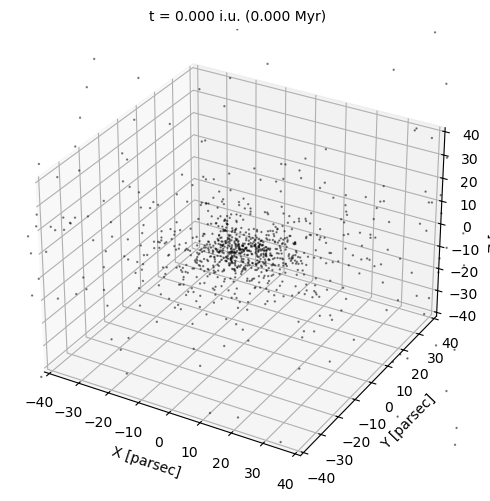

In [122]:
view(kuz_1,r_max = 40)

In [124]:
indexes = []
for i in range(15):
    r_min = i * 10
    r_max = (i + 1) * 10
    stars_in_bin = [star for star in kuz_1.system[0] if r_min < star.r < r_max]
    if stars_in_bin:
        lucky_star = random.choice(stars_in_bin)  # Randomly select the lucky star
        lucky_index = np.where(kuz_1.system[0] == lucky_star)[0][0]  # Find the index of the lucky star
        indexes.append(lucky_index)


In [125]:
evolve(kuz_1,tstop = 20,dt = 0.02,dtout=0.2,eps=0.001,theta = 1,orbit_indexes=indexes)

Evolving system:   0%|          | 0/20 [00:00<?, ?it/s]

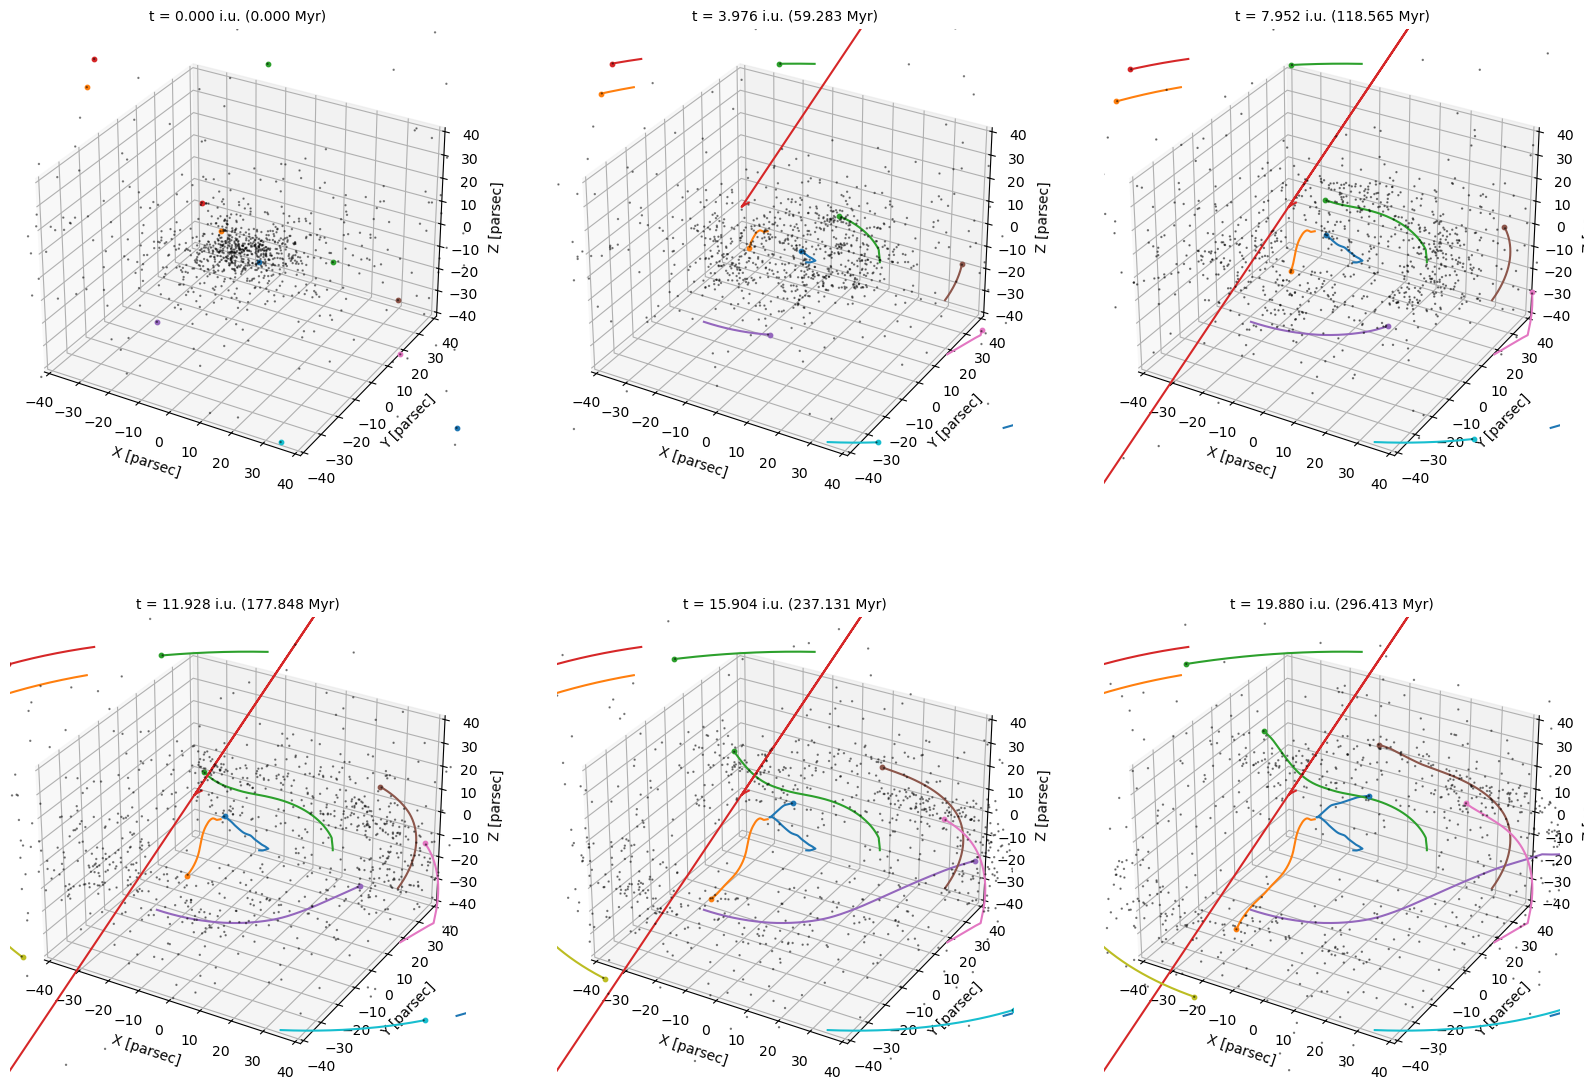

In [131]:
view(kuz_1,r_max=40,t=np.linspace(kuz_1.t[0],kuz_1.t[-1],6))

In [116]:
kuz_2 = Kuzmin_Toomre(N = 1000,a = 10, m = 1, Q = 0)

Kuzmin-Toomre disk with 1000 stars of mass 1.00 solar masses. Scale parameter a parameter is 10.00 parsecs. Toomre parameter Q is 0.00
Characteristic velocity is 6.15e+00 in internal units, 4.03e-01 km/s. 
Characteristic orbital period is 1.70e+01 in internal units, 2.54e+02 Myr. 


In [117]:
indexes = []
for i in range(15):
    r_min = i * 10
    r_max = (i + 1) * 10
    stars_in_bin = [star for star in kuz_2.system[0] if r_min < star.r < r_max]
    if stars_in_bin:
        lucky_star = random.choice(stars_in_bin)  # Randomly select the lucky star
        lucky_index = np.where(kuz_2.system[0] == lucky_star)[0][0]  # Find the index of the lucky star
        indexes.append(lucky_index)


In [118]:
evolve(kuz_2,tstop = 2,dt = 0.01,dtout=0.2,eps=0.001,theta = 1,orbit_indexes=indexes)

Evolving system:   0%|          | 0/2 [00:00<?, ?it/s]

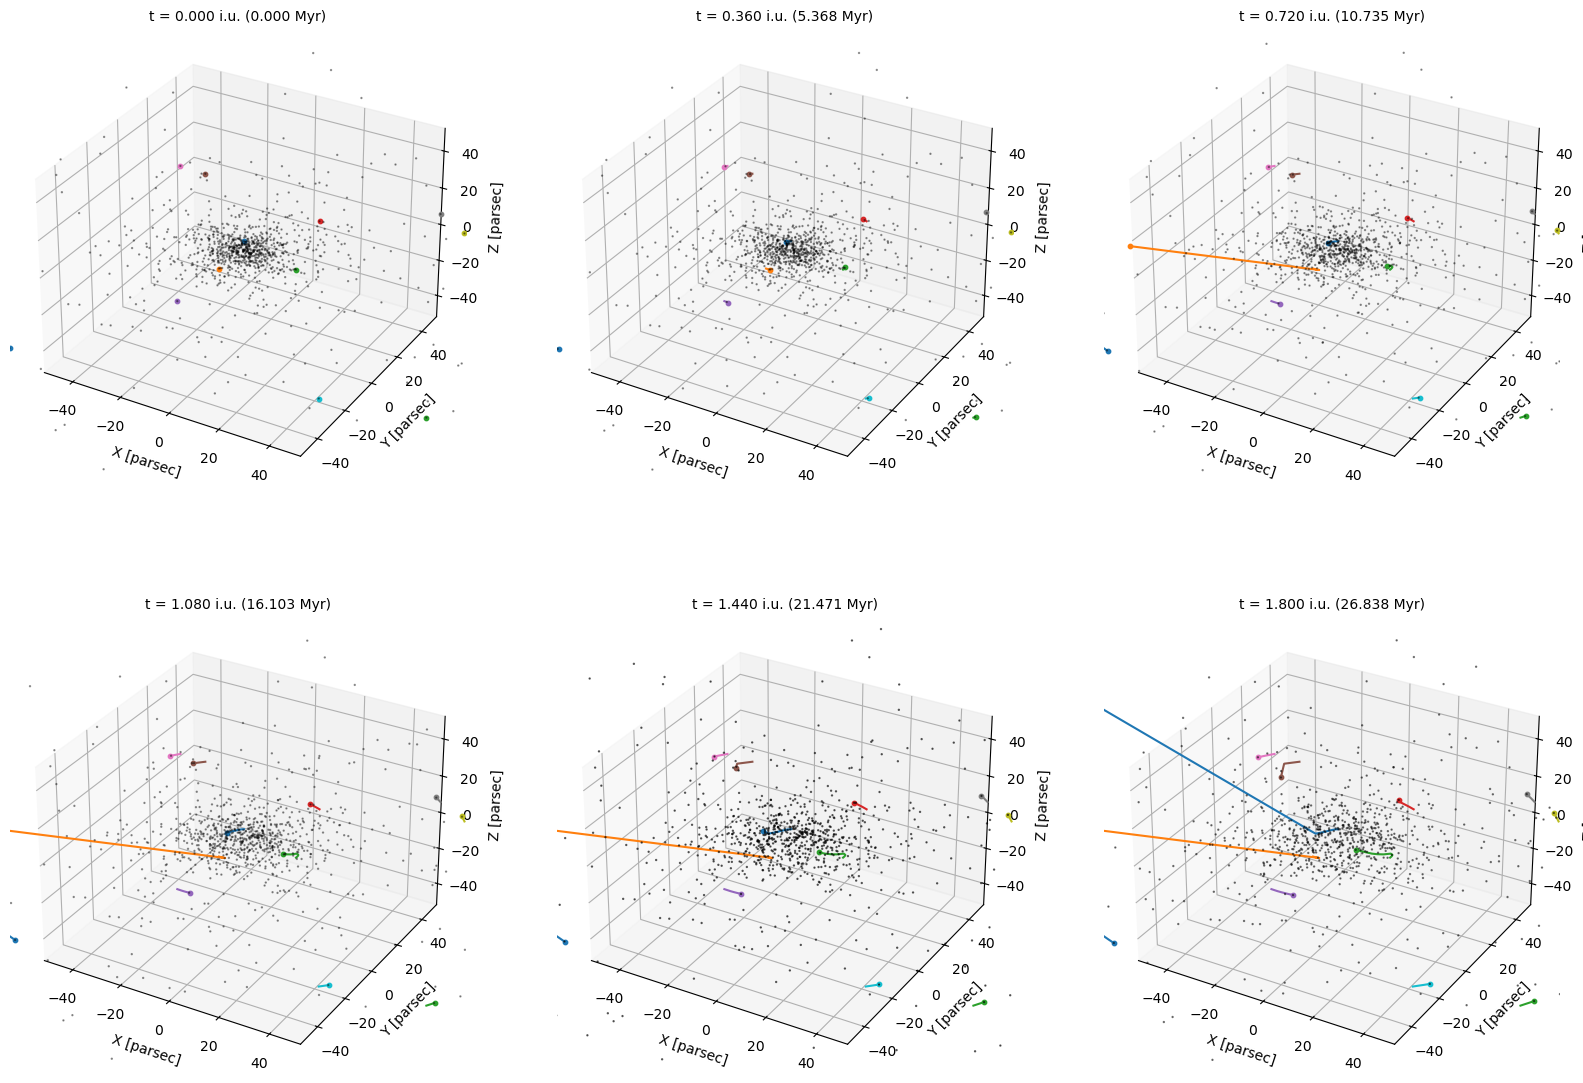

In [119]:
view(kuz_2,r_max=50,t=np.linspace(kuz_2.t[0],kuz_2.t[-1],6))

In [89]:
kuz = Kuzmin_Toomre(N = 1000,a = 100, Q = 1.5)

Kuzmin-Toomre disk with 1000 stars of mass 1.00 solar masses. Scale parameter a parameter is 100.00 parsecs. Toomre parameter Q is 1.50
Characteristic velocity is 1.94e+00 in internal units, 1.28e-01 km/s. 
Characteristic orbital period is 5.41e+02 in internal units, 8.06e+03 Myr. 


In [90]:
evolve(kuz,tstop = 100,dt = 5,dtout=10,eps=0.001,orbit_indexes=indexes)

Evolving system:   0%|          | 0/100 [00:00<?, ?it/s]

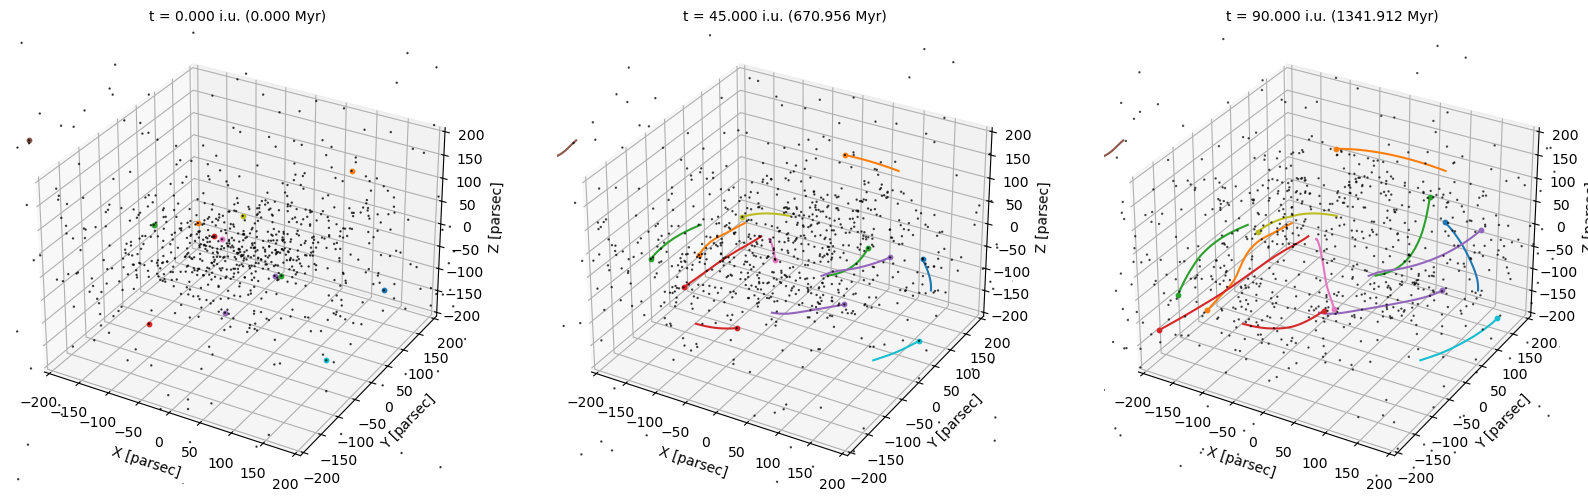

In [91]:
view(kuz,r_max=200,t=np.linspace(kuz.t[0],kuz.t[-1],3))



**GENERATING MIYAMOTO-NAGAI DISK**

$$p(R,z) = \frac{1}{M} 2 \pi R \rho(R,z) = \frac{1}{M} 2 \pi R \left(\frac{b^2M}{4\pi} \right)    \frac{aR^2 + (a+3\sqrt{z^2+b^2})(a+\sqrt{z^2+b^2})^2}{ [R^2+(a+\sqrt{z^2+b^2})^2]^{5/2}(z^2+b^2)^{3/2}  }$$

$$p(R,z) = \frac{1}{M} 2 \pi R \frac{\nabla^2\Phi}{4\pi G} = \frac{1}{2GM} \left(\frac{\partial}{\partial R}\left(R \frac{\partial\Phi}{\partial R} \right) + R\frac{\partial^2\Phi}{\partial^2 z}\right)$$

$$P(R,z)=\int_0^R \int_0^z p(R,z)dRdz = \int_0^R  ##$$

$$R(P)=####$$

In [4]:
time_conv = 0.067069 #1 Myr in internal units
velocity_conv = 15.248335 #Km/s in internal units

##k Boltzmann in internal units??

class Star:
    def __init__(self, m, x, v): #x is the cartesian coordinate vector, v the cartesian velocity
        self.m = m
        self.position = np.array(x)
        self.velocity = np.array(v)
        self.r = np.sqrt(x[0]**2+x[1]**2+x[2]**2) 
        self.v = np.sqrt(v[0]**2+v[1]**2+v[2]**2) #magnitude of velocity
        self.kinetic_energy = (0.5)*self.m*self.v**2 #expressed in internal units
        self.L = self.m*np.array([x[1]*v[2]-x[2]*v[1],x[2]*v[0]-x[0]*v[2],x[0]*v[1]-x[1]*v[0]])
        self.l = np.sqrt(self.L[0]**2+self.L[1]**2+self.L[2]**2)



class Galaxy:
    def __init__(self,N,eps,v_lim,kind):
        self.N = N
        self.v_lim = v_lim
        self.eps = eps
        self.kind = kind
        self.n_body_system = [] #list of stars objects
        self.P = [] #list of position objects
        self.t = [0] 
        self.E_tot = [] ; self.T = [] ; self.U = [] ; self.T_U_ratio = []
        self.dynamical_time = 0 ; self.t_cross = 0 ; self.t_relax = 0 #will be initialized

        self.perturber_index = []


    #FILLS self.t,self.n_body_system
    def evolve_treecode(self,filename,dtime,tstop,theta=1):
        dtout=dtime
        
        if os.path.exists("%s.in" %filename):
          os.remove("%s.in" %filename) 
        if os.path.exists("%s.out" %filename):
          os.remove("%s.out" %filename)

        #cancel all elements from arrays!!!!!!!!!!!!!
        
        #writes initial conditions in file for treecode
        initial_conditions_file = open("%s.in" %filename, "w") 
        initial_conditions_file.write(str(self.N)+"\n") #number of bodies
        initial_conditions_file.write(str(3)+"\n") #dimensions 
        initial_conditions_file.write(str(0.)+"\n") #initial time
    
        for star in self.n_body_system[0]:
            initial_conditions_file.write(str(star.m)+"\n")   
        for star in self.n_body_system[0]:
            initial_conditions_file.write(str(star.position[0])+"\t"+str(star.position[1])+"\t"+str(star.position[2])+"\n")
        for star in self.n_body_system[0]:
            initial_conditions_file.write(str(star.velocity[0])+"\t"+str(star.velocity[1])+"\t"+str(star.velocity[2])+"\n")
        initial_conditions_file.close()

        logfile = open("%s_logfile" %filename, "w")
        subprocess.call(["./treecode", "in=%s.in" %filename, "out=%s.out" %filename, "dtime=%f" %dtime, "theta=%f" %theta, "eps=%f" %self.eps, "tstop=%f" %tstop, "dtout=%f" %dtout],stdout=logfile) 

        #cancels initial conditions and writes them again
        self.n_body_system.clear()
        self.t.clear()
        #opens the output file and writes star's positions array for each time in t
        output = open("%s.out" %filename, "r").readlines()
        #makes array of array of star
        for i in range(int(len(output)/(3*self.N+3))):
            #self.t.append(float(output[i*(3*self.N+3)+2])) #time in internal units
            stars = []
            for j in range(self.N): 
                m = output[i*(3*self.N+3)+3+j]
                p = output[i*(3*self.N+3)+3+self.N+j]
                #float(output[i*(self.N+2)+(2+j)].split()[1])
                v = output[i*(3*self.N+3)+3+2*self.N+j]
                stars.append(Star(float(m),[float(p.split()[0]),float(p.split()[1]),float(p.split()[2])],[float(v.split()[0]),float(v.split()[1]),float(v.split()[2])]))     
            self.n_body_system.append(stars)
            
        #opens logfile and writes energy for each time in t 
        output = open("%s_logfile" %filename, "r").readlines()
        for i in range(len(self.n_body_system)): #-2??
            self.t.append(float(output[10+i*8].split()[0])) #time in internal units
            self.E_tot.append(float(output[10+i*8].split()[1]))
            self.T.append(float(output[10+i*8].split()[2]))
            self.U.append(float(output[10+i*8].split()[3]))
            self.T_U_ratio.append(float(output[10+i*8].split()[4]))
        self.t = np.array(self.t) 

        #creates array very usefull for animations
        positions_at_given_frame = []
        for frame in self.n_body_system:
            position_of_nth_star = []
            for star in frame:
                position_of_nth_star.append([star.position[0],star.position[1],star.position[2]])
            positions_at_given_frame.append(np.array(position_of_nth_star))
        self.P = np.array(positions_at_given_frame)

        print("Galaxy evolved to time %.2f: %s frames" %(self.t[-1],len(self.n_body_system)))


    
    def upload_treecode(self,filename): #if output already existent

        #opens the output file and writes star's positions array for each time in t
        output = open("%s.out" %filename, "r").readlines()
        #makes array of array of star
        for i in range(int(len(output)/(3*self.N+3))):
            self.t.append(float(output[i*(3*self.N+3)+2])) #time in internal units
            stars = []
            for j in range(self.N): 
                m = output[i*(3*self.N+3)+3+j]
                p = output[i*(3*self.N+3)+3+self.N+j]
                #float(output[i*(self.N+2)+(2+j)].split()[1])
                v = output[i*(3*self.N+3)+3+2*self.N+j]
                stars.append(Star(float(m),[float(p.split()[0]),float(p.split()[1]),float(p.split()[2])],[float(v.split()[0]),float(v.split()[1]),float(v.split()[2])]))
            self.n_body_system.append(stars)
            
        print("Galaxy evolved to time %.2f: %s frames" %(self.t[-1],len(self.n_body_system)))




    
    ########################################################################################################################################


    def view(self,r_max,time=0,index_orbits = []):

        if time > self.t[-1]: time=self.t[-1] 
        frame = np.digitize(time,self.t)-1
            
        fig = plt.figure(figsize=(10, 10)) ; ax = fig.add_subplot(projection='3d') ; 
        ax.set_xlim3d(-r_max, r_max) ; ax.set_ylim3d(-r_max, r_max) ; ax.set_zlim3d(-r_max, r_max) 
        ax.set_xlabel('X [parsec]') ; ax.set_ylabel('Y [parsec]') ; ax.set_zlabel('Z [parsec]') ; ax.set_aspect("equal") ;  # Provide starting angle for the view. #ax.view_init(25, 10)
        plt.title(self.kind + ": time %.2f = %f Myrs = %f of dynamical time" %(self.t[frame],self.t[frame]*time_conv,self.t[frame]/self.dynamical_time))

        ax.scatter(self.P[frame,:,0],self.P[frame,:,1],self.P[frame,:,2],c='black',s=0.5)
        for j in index_orbits:
            plt.plot(self.P[:frame,j,0],self.P[:frame,j,1],self.P[:frame,j,2])
            ax.scatter(self.P[frame,j,0],self.P[frame,j,1],self.P[frame,j,2],s=5)

        for k in self.perturber_index:
            plt.plot(self.P[:frame,k,0],self.P[:frame,k,1],self.P[:frame,k,2],c='red')
            ax.scatter(self.P[frame,k,0],self.P[frame,k,1],self.P[frame,k,2],c='red',s=20)

            #kk = self.perturber_index[0]
            #ax.scatter(self.P[frame,:kk,0],self.P[frame,:kk,1],self.P[frame,:kk,2],c="black",s=0.5,alpha=0.5) #first frame or last frame?
        
        plt.show()




    ########################################################################################################################



    def LOS_velocity_dispersion(self,i=0,alpha=0,gamma=0,angular_resolution=1000,FOV=1.e5,distance=1000,time=0):

        if time > self.t[-1]: time=self.t[-1] 
        frame = np.digitize(time,self.t)-1

        #conv = 206265/distance #arcsec
        conv = 3437.75/distance #arcmin
        beta = np.pi/2-i #i inclination angle
        
        LOS = np.array([cos(alpha)*cos(beta),sin(alpha)*cos(beta),-sin(beta)])
        ra_vector = np.array([cos(alpha)*sin(beta)*sin(gamma) + sin(alpha)*cos(gamma),sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma),cos(beta)*sin(gamma)])
        dec_vector = np.array([cos(alpha)*sin(beta)*cos(gamma) + sin(alpha)*sin(gamma),sin(alpha)*sin(beta)*cos(gamma) - cos(alpha)*sin(gamma),cos(beta)*cos(gamma)])
 
        ra = [] ; dec = [] ; v_LOS = []
        for star in self.n_body_system[frame]: 
            ra.append(np.dot(star.position,ra_vector)*conv)
            dec.append(np.dot(star.position,dec_vector)*conv)
            v_LOS.append(np.dot(star.velocity,LOS))  

        bins = [np.arange(-FOV/2, FOV/2 + angular_resolution, angular_resolution),np.arange(-FOV/2, FOV/2 + angular_resolution, angular_resolution)]
        LOS_v_matrix = [[ [] for _ in range(len(bins[0]))] for _ in range(len(bins[1]))]
        
        for k in range(self.N):
            i,j = np.digitize(ra[k],bins[0]), np.digitize(dec[k],bins[1]) 
            if i != 0 and j != 0 and i != len(bins[0]) and j != len(bins[1]): 
                LOS_v_matrix[i-1][j-1].append(float(v_LOS[k]))

        
        LOS_v_mean = np.zeros((len(bins[1]),len(bins[0]))) ; LOS_v_dispersion = np.zeros((len(bins[1]),len(bins[0])))
        for i in range(len(bins[1])):
                for j in range(len(bins[0])):
                    if len(LOS_v_matrix[j][i]) == 0: #sensibility condition??
                        LOS_v_mean[i][j] = 0.
                        LOS_v_dispersion[i][j] = 0.
                    else:
                        LOS_v_mean[i][j] = np.mean(LOS_v_matrix[j][i]) 
                        LOS_v_dispersion[i][j] = np.std(LOS_v_matrix[j][i])

        
        fig, axes = plt.subplots(1, 3, figsize=(12,4),layout="constrained") 
        fig.suptitle('Luminosity, LOS velocity and dispersion') #fontsize=12
        for i in range(3):
            axes[i].set_aspect('equal') ; axes[i].set_xlabel("ra [']") ; axes[i].set_ylabel("dec [']")
            
        pl0 = axes[0].hist2d(ra, dec, bins=[np.arange(-FOV/2, FOV/2 + angular_resolution, angular_resolution),np.arange(-FOV/2, FOV/2 + angular_resolution, angular_resolution)],cmap=cm.gray) #sensibility condition
        fig.colorbar(pl0[3], ax=axes[0], location='bottom', shrink=0.5, label="surface brightness")
        
        pl1 = axes[1].imshow(LOS_v_mean, interpolation='none', extent=[-FOV/2, FOV/2,-FOV/2, FOV/2],origin='lower',cmap=cm.bwr)  #origin='lower' #aspect='auto' #norm=mcolors.LogNorm(vmin=c_min,vmax=c_max)
        fig.colorbar(pl1, ax=axes[1], location='bottom', shrink=0.5, label="$v_\parallel$")

        pl2 = axes[2].imshow(LOS_v_dispersion, interpolation='none', extent=[-FOV/2, FOV/2,-FOV/2, FOV/2], origin='lower',cmap=cm.viridis,vmin=10**-10) #aspect='auto' #norm=mcolors.LogNorm(vmin=c_min,vmax=c_max)
        fig.colorbar(pl2, ax=axes[2], location='bottom', shrink=0.5, label="$\sigma_\parallel$")

        plt.show()





    ##########################################################################################################################




    
    def virial(self): 
        fig, ax = plt.subplots(1,2,figsize=(10,6))

        ax[0].plot(self.t,self.E_tot, c='g',label='$E_{tot}$')
        ax[0].plot(self.t,self.T, c='r',label='T')
        ax[0].plot(self.t,self.U, c='blue',label='-U')
        ax[0].set_xlabel("t [internal_units]") ; ax[0].set_ylabel("energy [internal units]")        
        ax[0].legend()
        ax[1].plot(self.t,self.T_U_ratio,c='black')
        ax[1].set_xlabel("t [internal_units]") ; ax[1].set_ylabel("T/U")  
        #ax[1].set_ylim(0,1)
        plt.show()


    #analysis on dynamical friction
    def perturber_motion_virtual(self,dynamical_friction,gravitational_force):
        if len(self.perturber_index) == 1:
            k = self.perturber_index[0]
            
            def perturber_equation_of_motion(X,t): #[x,y,z,vx,vy,vz]
                r = np.sqrt(X[0]**2+X[1]**2+X[2]**2)
                p = np.array([X[0],X[1],X[2]])
                versor_r = p/r
                v = np.sqrt(X[3]**2+X[4]**2+X[5]**2)
                V = np.array([X[3],X[4],X[5]])
                versor_v = V/v
                F = gravitational_force(r)*versor_r + dynamical_friction(r,v)*versor_v        
                return [X[3],X[4],X[5],F[0],F[1],F[2]]

            # initial condition 
            p0 = self.n_body_system[0][k].position
            print(p0)
            v0 = self.n_body_system[0][k].velocity
            X0 = [p0[0],p0[1],p0[2],v0[0],v0[1],v0[2]]
            # values of time 
            t = np.linspace(0,self.t[-1],5000) 
              
            # solving ODE 
            solution = odeint(perturber_equation_of_motion, X0, t)
            x = np.array(solution[:,0]) ; y = np.array(solution[:,1]) ; z = np.array(solution[:,2])
            vx = np.array(solution[:,3]) ; vy = np.array(solution[:,4]) ; vz = np.array(solution[:,5])
            r_pred = np.sqrt(x**2+y**2+z**2)
            v_pred = np.sqrt(vx**2+vy**2+vz**2)
            M_pert = self.n_body_system[0][k].m
            l_pred = M_pert*np.sqrt((y*vz-z*vy)**2+(z*vx-x*vz)**2+(x*vy-y*vx)**2)

            R_pert = [] ; V_pert = [] ; l_pert = [] 
            for frame in range(len(self.n_body_system)):
                R_pert.append(self.n_body_system[frame][k].r)
                V_pert.append(self.n_body_system[frame][k].v)
                l_pert.append(self.n_body_system[frame][k].l)
            R_pert = np.array(R_pert) ; V_pert = np.array(V_pert) ; l_pert = np.array(l_pert)

            fig, ax = plt.subplots(1, 3, figsize=(10,6),layout="constrained") 
            fig.suptitle('Position, velocity and angular momentum evolution of perturber') #fontsize=12
            
            ax[0].scatter(self.t*time_conv,R_pert)
            ax[0].plot(t*time_conv,r_pred,c='orange')
            ax[0].set_xlabel("time [Myrs") ; ax[0].set_ylabel("r [parsecs]")
            
            
            ax[1].scatter(self.t*time_conv,V_pert*velocity_conv)
            ax[1].plot(t*time_conv,v_pred*velocity_conv,c='orange')
            #ax[1].set_ylim(0,1.5**velocity_conv)
            ax[1].set_xlabel("time [Myrs]") ; ax[1].set_ylabel("velocity [km/s]")
            
            ax[2].scatter(self.t*time_conv,l_pert) #*velocity_conv
            ax[2].plot(t*time_conv,l_pred,c='orange')
            #ax[1].set_ylim(0,1.5*v0)
            ax[2].set_xlabel("time [Myrs]") ; ax[2].set_ylabel("angular momentum [iu]")
            
            plt.show()
            



In [5]:
def perturber(galaxy,M_p,R_p,V_p):
    pert = Star(M_p,R_p,V_p)
    galaxy.n_body_system[0] = np.append(galaxy.n_body_system[0], pert)
    galaxy.perturber_index.append(galaxy.N) #index at which the perturber is
    galaxy.N = galaxy.N + 1
    galaxy.perturber = True


In [6]:
def merger(galaxy_1,galaxy_2,r1,r2,v1,v2):

    N = galaxy_1.N + galaxy_2.N
    eps = min(galaxy_1.eps,galaxy_2.eps)
    v_lim = 50 #????

    galactic_merger = Galaxy(N,eps,v_lim,"merger")
    
    initial_system = []
    for star in galaxy_1.n_body_system[0]:
        star.position = star.position + r1
        star.velocity = star.velocity + v1
        initial_system.append(star)
    
    for star in galaxy_2.n_body_system[0]:
        star.position = star.position + r2
        star.velocity = star.velocity + v2
        initial_system.append(star)

    galactic_merger.n_body_system.append(initial_system)
    for i in range(len(galaxy_2.perturber_index)):
        galaxy_2.perturber_index[i] = galaxy_2.perturber_index[i] + galaxy_1.N
    galactic_merger.perturber_index = galaxy_1.perturber_index + galaxy_2.perturber_index

    return galactic_merger

In [7]:
class Mestel(Galaxy):
    def __init__(self,N,v_0,q,m=1):
        self.N = int(N) ; self.v_0 = v_0 ; self.m = m ; self.M = self.N*self.m 
        
        #self.v_0 = 2*np.pi*self.Sigma_0*self.R_0
        self.R_max = self.M/self.v_0**2
        self.q = q 
        self.sigma = self.v_0**2/np.sqrt(self.q+1)
        print(self.sigma)
        self.eps = ((4/3)*np.pi*self.R_max**3/self.N)**(1/3)  #?????
        self.v_escape_max = self.v_0 #?????
        super().__init__(self.N,self.eps,self.v_escape_max,"Mestel disk")

        Sigma_0 = self.M/(np.pi*self.R_max**2)
        F = (Sigma_0 * self.v_0**self.q)/(2**(self.q/2)*np.sqrt(np.pi)* math.factorial(int(1/2*self.q-1/2)) * self.sigma**(self.q+2)) #problem with factorial

        initial_system = [] ; r_pol = [] ; vel_phi = [] ; vel_R = []
        
        for i in range(self.N):
            u = random.uniform(0,1); w = random.uniform(0,1); 
            R = u*self.M/self.v_0**2 ; #r_pol.append(R)
            phi = 2*np.pi*w 
            pos_cart = [R*np.cos(phi),R*np.sin(phi),0.0]

            counter = 0
            check_counter = 0
            #while(counter == 0 and check_counter<100):
            #    f_trial_log = random.uniform(-100,0)
            #    v_phi = random.uniform(0,2*self.v_0) #???? determines v_phi
            #    v_R = np.random.normal(0,self.sigma) #determines v_R
            #    Lz = R*self.m*v_phi
            #    pot = -self.v_0**2 * np.log(R/self.R_max) #??
            #    E = pot - 1/2 * (v_R**2 + v_phi**2)
            #    f = (Lz/(self.R_max*self.v_0))**q * np.exp(E/self.sigma**2) #*F
                #print(np.log(f))
                #print(f_trial_log)
            #    if f_trial_log < np.log(f):
            #        print(v_phi)
            #        print(v_R)
            #        counter = 1
            #        check_counter = check_counter + 1
            v_phi = self.v_0
            sigma_R = self.q * (self.v_0**2/(2*np.pi*R))/(self.v_0/R)
            v_R = np.random.normal(0,sigma_R) #0
            #print(v_R)
            vel_cart = [-v_phi*np.sin(phi)-v_R*np.cos(phi),v_phi*np.cos(phi)-v_R*np.sin(phi),0.0] 
            initial_system.append(Star(self.m, pos_cart, vel_cart))
            vel_phi.append(v_phi)
            vel_R.append(v_R)

            
        self.n_body_system.append(np.array(initial_system))

        #self.r_median = np.median(r_pol) ; self.v_median = np.median(v_phi)
        self.t_cross = 1 #self.r_median/self.v_median
        self.dynamical_time = 1 # self.t_cross
        self.t_orbit = 1 #2*np.pi*self.r_median/(self.r_median * self.M**(1/2) * (self.r_median**2+self.a**2)**(-3/4))
        self.t_relax = 1 #(0.1*N/np.log(N))*self.t_cross




In [8]:
mestel = Mestel(1000,10,q=2)

57.73502691896258


In [9]:
mestel.evolve_treecode("mestel",0.1,10)

Galaxy evolved to time 10.00: 101 frames


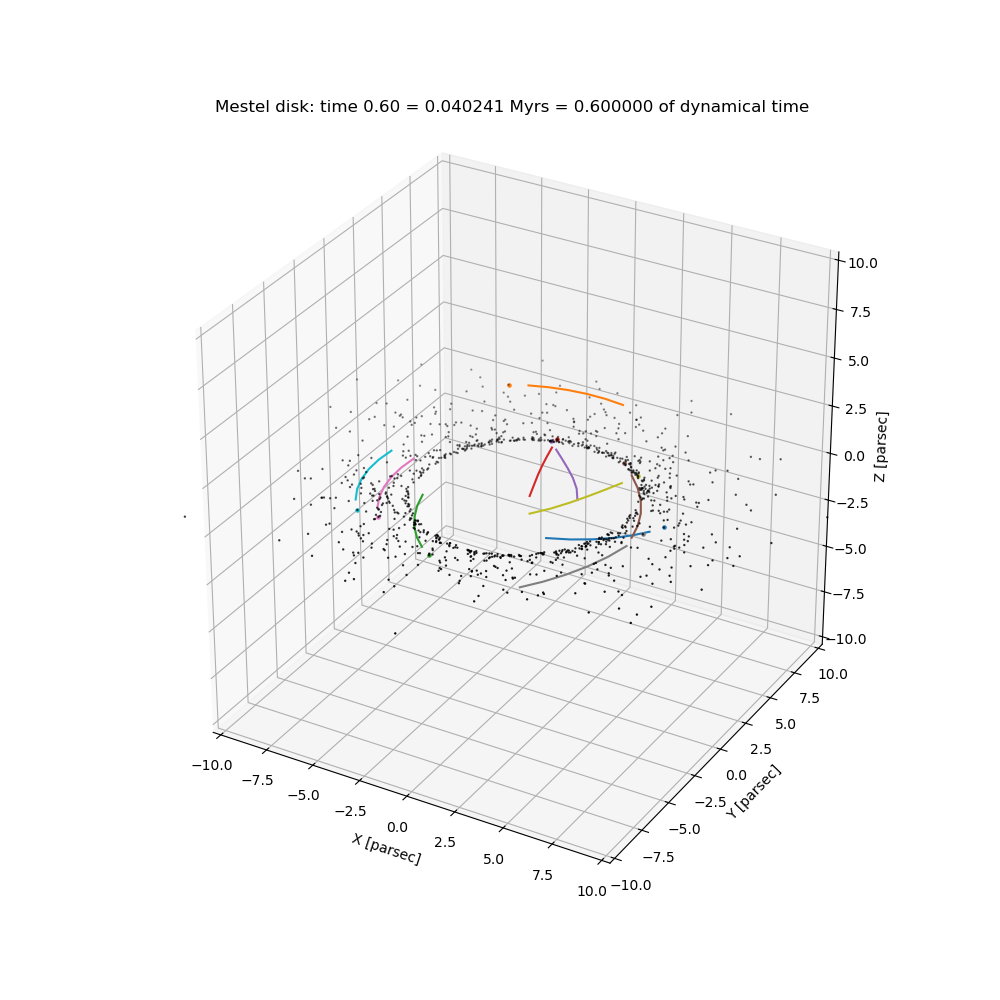

In [16]:
%matplotlib widget

mestel.view(r_max=10,time=0.6,index_orbits=np.arange(0,10,1)) #=[1,2,3,4,5,6,7,8,9,10]

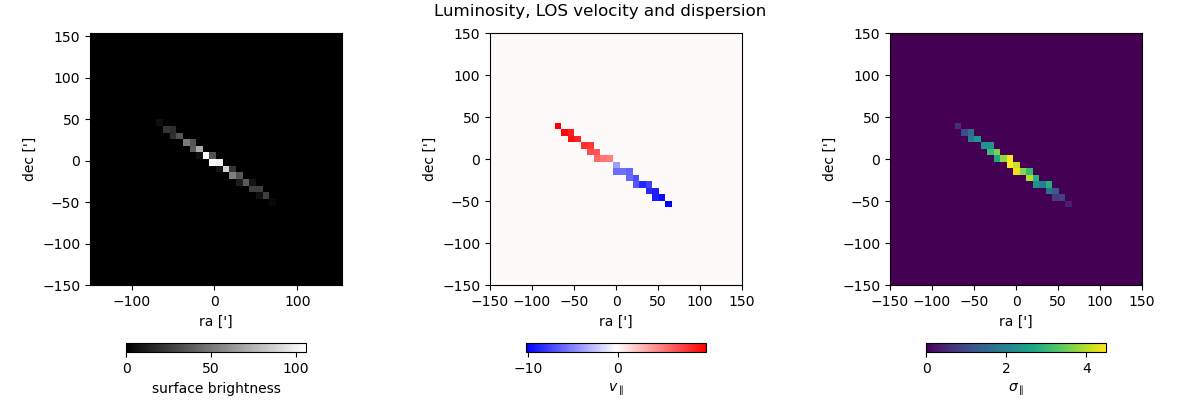

In [11]:
mestel.LOS_velocity_dispersion(i=np.pi/2,alpha=0.,gamma=0.6,angular_resolution=8,FOV=300,distance=400,time=0)

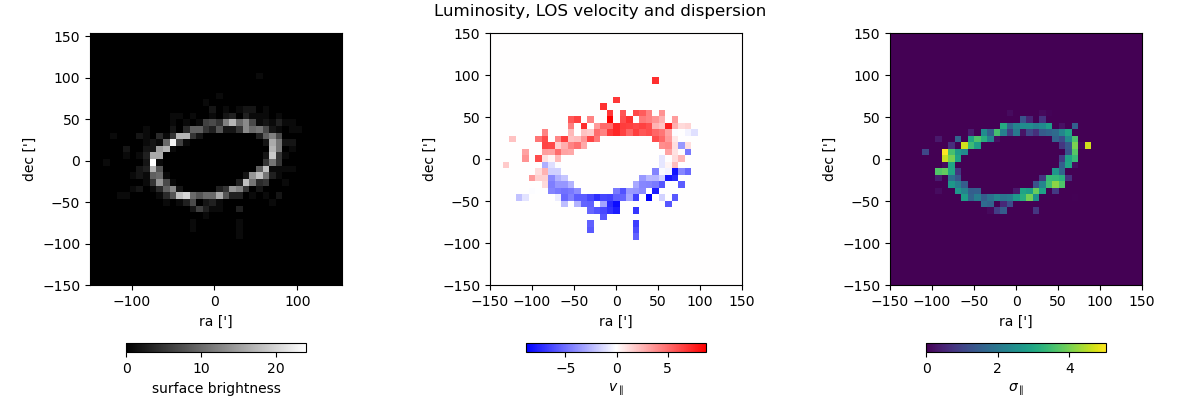

In [143]:
mestel.LOS_velocity_dispersion(i=np.pi/3,alpha=0.5,gamma=0.6,angular_resolution=8,FOV=300,distance=400,time=1)

In [48]:
class Miyamoto_Nagai(Galaxy):
    def __init__(self,N,a,b,m=1):
        self.N = int(N) ; self.a = a ; self.b = b ; self.m = m ; self.M = self.N*self.m ; 
        self.v_escape_max = np.sqrt(2*self.M/self.a)
        super().__init__(N,10*max(a,b),self.v_escape_max,"Miyamoto-Nagai disk")
        

        def density_distribution(R,z):
            return (1/self.M) * 2*np.pi*R* (self.b**2 * self.M/(4*np.pi)) * (self.a * R**2 + (self.a + 3*np.sqrt(z**2+self.b**2))*(self.a+np.sqrt(z**2+self.b**2))**2) / ((R**2+(self.a+np.sqrt(z**2+self.b**2))**2)**(5/2) *(z**2+self.b**2)**(3/2))
            
        
        initial_system = [] #stars            
        while(len(initial_system)<self.N): 
            R = random.uniform(0,self.r_lim); z = random.uniform(-self.r_lim/2,self.r_lim/2) ; p = random.uniform(0,self.r_lim/self.M)#this is probability  
            if density_distribution(R,z) < p:
                phi = random.uniform(0,2*np.pi)
                pos_cart = [R*np.cos(phi),R*np.sin(phi),z] 
                vel_cart = [0,0,0] 
                initial_system.append(Star(self.m, pos_cart, vel_cart))
        self.n_body_system.append(np.array(initial_system))

In [49]:
g = Miyamoto_Nagai(10000,1,0.1)

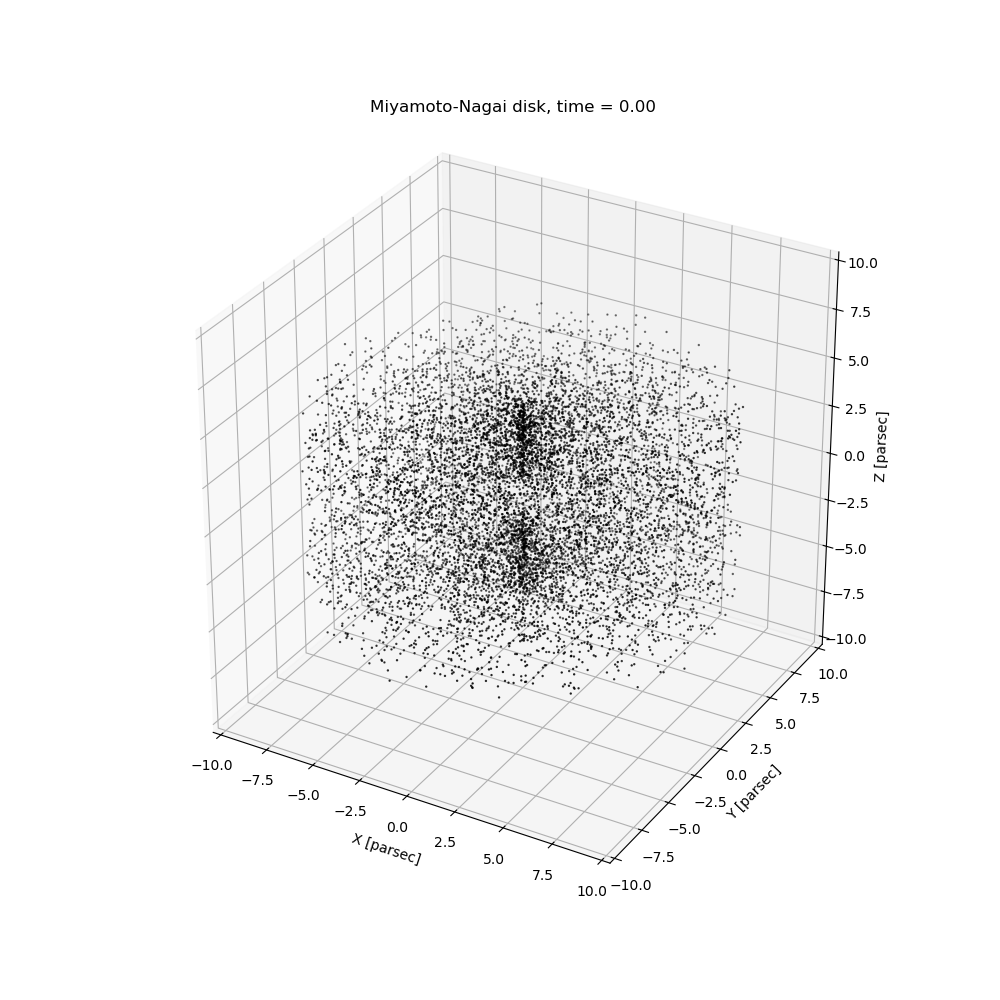

In [50]:
%matplotlib widget
g.view()

In [ ]:
    def evolve_nbody_sh1(self,filename):
        #writes initial conditions in file for nbody_sh1

        initial_conditions = open("%s.in" %filename, "w") 
        initial_conditions.write(str(self.N)+"\n")
        initial_conditions.write(str(0)+"\n")
        for star in self.initial_star_collection: #works with sorted array
            initial_conditions.write(str(self.m)+"\t"+str(star.position[0])+"\t"+str(star.position[1])+"\t"+str(star.position[2])+"\t"+str(star.velocity[0])+"\t"+str(star.velocity[1])+"\t"+str(star.velocity[2])+"\n")
        initial_conditions.close()

        #subprocess.run(["./nbody_sh1", "-d 0.03", "-e 1.0", "-o 0.01", "-t %f", "< %s.in", "> %s.out"] %(t_stop,filename,filename))
        
        #opens the output file and writes star's positions array for each time in t
        output = open("%s.out" %self.filename, "r").readlines()
        #makes array of array of star
        for i in range(int(len(output)/(self.N+2))):
            self.t.append(float(output[i*(self.N+2)+1])) #time in internal units
            stars = []
            for j in range(self.N): 
                stars.append(Star(self.m, [float(output[i*(self.N+2)+(2+j)].split()[1]),float(output[i*(self.N+2)+(2+j)].split()[2]),float(output[i*(self.N+2)+(2+j)].split()[3])], [float(output[i*(self.N+2)+(2+j)].split()[4]),float(output[i*(self.N+2)+(2+j)].split()[5]),float(output[i*(self.N+2)+(2+j)].split()[6])]))
            self.n_body_system.append(stars)
            
        print("Galaxy evolved to time %.2f: %s frames" %(self.t[-1],len(self.n_body_system)))

In [ ]:
class NFW(Galaxy):
    def __init__(self,N,a,m=1): #M_BH=0 self.N=N+1
        self.N = N ; self.a = a ; self.m = m ; self.M = self.N*self.m
        self.eps = 10**-4 * ((4/3)*np.pi*self.a**3/self.N)**(1/3) #treecode
        self.rho0 = self.M/(2*np.pi*self.a**3)
        
        self.v_escape_max = 1 # np.sqrt(4*np.pi*self.rho0*self.a**2) 
        
        super().__init__(self.N,self.eps,self.v_escape_max,"NFW") 
        
        #print("Hernquist galaxy of %i stars of mass %.2f. Central density is %.2f solar masses for parsec cube, scale parameter a is %.2f parsecs" %(self.N, self.m, self.rho0, self.a))
        
        def potential(r):
            return -4*np.pi*self.rho0*self.a**2 * np.log(1+r/self.a)/(r/self.a)     
        
        #def DF(v,phi):
        #    E = phi-(1/2)*v**2
        #    E_tilde = E*self.a/self.M #sommare anche la massa del buco nero? ??
        #    return (np.sqrt(E_tilde)/(np.sqrt(2)*(2*np.pi)**3 *(self.M*self.a)**(3/2)*(1-E_tilde)**2))*((1-2*E_tilde)*(8*E_tilde**2-8*E_tilde-3) +3*np.arcsin(np.sqrt(E_tilde))/np.sqrt(E_tilde*(1-E_tilde)))

        #Phi_find_max = np.linspace(10**-8,self.M/self.a,500) 
        #max_values = []
        #for phi in Phi_find_max: 
        #    v = np.linspace(0,np.sqrt(2*phi))
        #    f = 4*np.pi*v**2 * DF(v,phi)
            #plt.plot(v,4*np.pi*v**2 * DF(v,phi))
            #print(max(f))
          #  max_values.append(max(f))
        #print(max_values)

        #start initializing density profile
        initial_system = [] ; R = [] ; V = []

        r_for_inv = np.linspace(0,10*self.a,500)
        mass_enclosured = 4*np.pi*self.rho0*self.a**3 * (np.log(1+r_for_inv/self.a)-(r_for_inv/self.a)/(1+r_for_inv/self.a))
        
        for i in range(self.N):
            m_r = random.uniform(0,self.M)
            j = np.digitize(m_r,mass_enclosured)-1
            r = r_for_inv[j]
            R.append(r)
            theta = np.arccos(1-2*random.uniform(0,1)) ; phi = 2*np.pi*random.uniform(0,1)
            pos_cart = [r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)]

            #generate velocity
            #Phi = -potential(r)
            #print(Phi/(self.M/self.a))
            #j = np.digitize(Phi,Phi_find_max)-1
            #print(j)
            #v = 0
            #bool = False
            
            if Phi/(self.M/self.a)<0.05:
                    print("ecco")

            while bool == False:
                v_random = random.uniform(0,np.sqrt(2*Phi))
                E = Phi - (1/2)*v_random**2
                y = random.uniform(0,max_values[j])
                if Phi/(self.M/self.a)<0.05:
                    print(4*np.pi*v_random**2 * DF(E))
                    print(y)
                if y < 4*np.pi*v_random**2 * DF(v_random,Phi): 
                    #print(v_random)
                    bool = True
                    v = v_random
            V.append(v)
            v = 0
            theta_v = np.arccos(1-2*random.uniform(0,1)) ; phi_v = 2*np.pi*random.uniform(0,1)
            vel_cart = [v*np.sin(theta_v)*np.cos(phi_v),v*np.sin(theta_v)*np.sin(phi_v),v*np.cos(theta_v)]
            initial_system.append(Star(self.m,pos_cart,vel_cart))
        self.n_body_system.append(np.array(initial_system))
            
 
        
        #initial_system = [] ; R=[] ; V = []
        #initial_system.append([Star(self.M_BH,[0,0,0],[0,0,0])]) #black hole. If it's mass is zero, it will have no effect

        #t_dynamical, t_cross and t_relax
        self.dynamical_time = np.sqrt(1/self.rho0) ##????
        self.r_median = np.median(R) ; self.v_median = np.median(V)
        self.t_cross = self.r_median/self.v_median
        self.t_relax = (0.1*N/np.log(N))*self.t_cross

print("t_dynamical time is %f in internal units, %f Myr. t_cross time is %f in internal units, %f Myr. t_relax time is %f in internal units, %f Myr" %(self.dynamical_time, self.dynamical_time*time_conv, self.t_cross, self.t_cross*time_conv,self.t_relax, self.t_relax*time_conv))
